### Первый эксперимент

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные.
Всего пользователям показывались три варианта:

* A – прямоугольные 16:9
* B – квадратные
* C – прямоугольные 12:4

Проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

#### Загрузим необходимые библиотеки

In [3]:
import pandas as pd
from scipy import stats
import scipy
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#### Загрузим данные и посмотрим на них

In [4]:
path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Lj5WClBbCt3fyw'

In [5]:
photo = pd.read_csv(path)

In [6]:
photo.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


#### Описание данных
* **id** – id клиента в эксперименте
* **group** – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
* **events** – сколько блюд суммарно было заказано за период

In [7]:
photo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


Количество наблюдений для каждого варианта фото:

In [8]:
photo.group.value_counts()

C    10000
A    10000
B    10000
Name: group, dtype: int64

Посмотрим для какого варианта фото среднее количество заказов блюд больше:

In [9]:
photo.groupby('group').events.mean()

group
A    29.5796
B    37.6136
C    27.4703
Name: events, dtype: float64

Как мы видим, среднее количество покупок больше для варианта B (квадратные фото).
Следует выяснить является ли это различие стат. значимым.

В данном случае необходимо сравнить три выборочных средних (A, B, C) между собой

Для этого используем однофакторный дисперсионный анализ ANOVA.

Основые требования однофакторного ANOVA к данным:

* Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена и критерия Бартлетта
* Если объем выборки недостаточно большой (меньше 30), то важно соблюдать требование о нормальности распределения двух выборок.

---
Для начала проверим гомогенность дисперсий внутри групп с помощью критерия Левена.

* **Нулевая гипотеза критерия (H0)** дисперсия в выборках гомогенна
* **Альтернативная гипотеза (H1)** дисперсия в выборках не гомогенна

Отвергать нулевую гипотезу будем при уровне p_value < 0.05

In [10]:
scipy.stats.levene(photo[photo.group == 'A'].events, photo[photo.group == 'B'].events, photo[photo.group == 'C'].events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Полученный pvalue = 0.104 не позволят нам отвергнуть нулевую гипотезу, а значит дисперссии в выборках гомогенны.

___

Хоть в нашем случае выборки содержат достаточно много наблюдений тем не менее проверим нормальность распределений в каждой группе при помощи критерия Шапиро-Уилка (Shapiro–Wilk test). Так как этот критерий довольно чувствителен к размеру выборки (при больших выборках может давать неверные результаты) ограничим размеры исследуемых выборок 1000 наблюдений.

* **Нулевая гипотеза (H0)** выборки получены из нормального распределения
* **Альтернативная гипотеза (H1)** выборка получены не из нормального распределения

Отвергать нулевую гипотезу будем при уровне p_value < 0.05


In [11]:
stats.shapiro(photo[photo.group == 'A'].events.sample(1000, random_state=17)) #здесь и далее для воспроизводимости результата используйте параметр random_state=17 в методе sample

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [12]:
stats.shapiro(photo[photo.group == 'B'].events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [13]:
stats.shapiro(photo[photo.group == 'C'].events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

Для всех трех групп полученные pvalue > 0.05 не позволяют отвергнуть нулевую гипотезу. А значит распределения во всех трех грппах можно считать нормальными.
___
Проведем непосредственно тест ANOVA

* **Нулевая гипотеза критерия (H0)** между средними в выборках нет различий
* **Альтернативная гипотеза (H1)** не все средние в выборках равны

Отвергать нулевую гипотезу будем при уровне p_value < 0.05


In [14]:
stats.f_oneway(photo[photo.group == 'A'].events,
               photo[photo.group == 'B'].events,
               photo[photo.group == 'C'].events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Тест показал что существуют стат. значимые различия между средними в группах. Однако, тест не позволяет определить мужду какими именно группами существуют различия.
Для того чтобы определить между какими именно группами существуют стат. значимые различия используем критерий Тьюки, который сравнивает выборки попарно между собой

* **Нулевая гипотеза критерия (H0)** между средними в выборках нет различий
* **Альтернативная гипотеза (H1)** средние в выборках стат. значимо различаются

In [15]:
MultiComp = MultiComparison(photo.events, photo.group)
print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Критерий Тьюки показал что существуют стат. значимые различия между всеми группами (A и B, A и C, B и C) (отвергается нулевая гипотеза). Наибольшее среднее в группе B.
**Значит следует использовать квадратные фотографии.**

### Второй эксперимент

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

#### Загрузим данные и посмотрим на них

In [16]:
path2 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Vnlvg9uOrMVKhw'

In [17]:
button = pd.read_csv(path2)

In [18]:
button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


#### Описание данных

* **d** – id клиента в эксперименте
* **segment** – сегмент (high/low)
* **group** – вид кнопки (control – старая версия, test – новая версия)
* **events** – сколько блюд суммарно было заказано за период

In [19]:
button.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


Распредление наблюдений по segment и group:

In [20]:
button.segment.value_counts()

low     80000
high    20000
Name: segment, dtype: int64

In [21]:
button.group.value_counts()

test       50000
control    50000
Name: group, dtype: int64

#### Визуализируем распределение event для контрольной и тестовой группы

In [23]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
) # настрока стиля и размеров графика

C:\Users\mexan\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


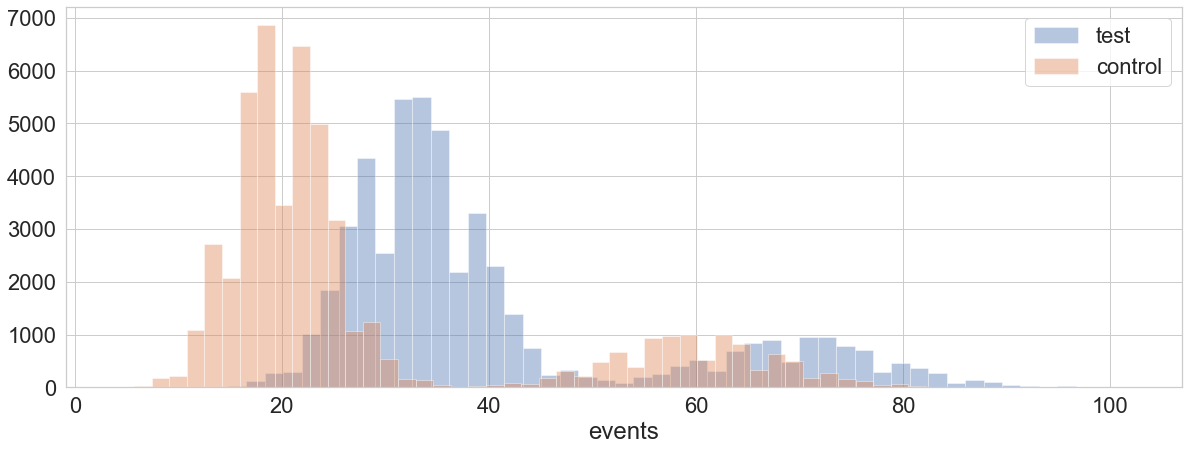

In [29]:
sns.distplot(button[button.group=='test'].events, kde = False)
sns.distplot(button[button.group=='control'].events, kde = False)
plt.legend(['test', 'control'])

#### Расчитаем основные показатели events (среднее, медиану и стандартное отклонение) в разрезе групп и сегмантов

In [33]:
button.groupby(['group', 'segment']).agg({'events': ['mean', 'median', 'std']})

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

Все показатели events отличаются в большую сторону в тестовой группе. Определим является ли это различие стат. значимым.
___

В данном эскперементе предстоит проверить действие 2 номинативных переменных (group и segment) на одну зависимую переменную (events), для этого следует использовать многофакторный дисперсионный анализ ANOVA.

Выберем формулу для модели:

***events ~ segment + group + segment:group*** (действие на зависимую переменную отдельно первой номинативной переменной + действие на зависимую переменную отдельно второй номинативной переменной + их совместное действие)



In [51]:
formula = 'events ~ segment + group + segment:group'

In [53]:
model = ols(formula, button).fit()
aov_table = anova_lm(model, typ=2)

In [54]:
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Как видно по последней колонке, значим как эффект обоих факторов, так и их взаимодействие.
___
Используя критерий Тьюки определим между какими гуппами есть статитически значимые различия.
Но сначала добавим к датафрейму колонку в которую поместим соответствующие комбинации qroup и segment, чтобы потом передать в аргумент groups MultiComparisom

In [55]:
button['combination'] = button['group']+'/'+button['segment']

In [56]:
button.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


Используем критерий Тьюки:

In [57]:
MultiComp = MultiComparison(button.events, button.combination)
print(MultiComp.tukeyhsd().summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control/high control/low -39.9392 0.001 -40.1073 -39.7711   True
control/high   test/high   9.9677 0.001   9.7551  10.1803   True
control/high    test/low -26.9449 0.001  -27.113 -26.7768   True
 control/low   test/high  49.9069 0.001  49.7388   50.075   True
 control/low    test/low  12.9944 0.001   12.888  13.1007   True
   test/high    test/low -36.9126 0.001 -37.0807 -36.7445   True
----------------------------------------------------------------


Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой

Разница между control/high и test/high составила около 10

Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

___

#### Визуализируем результаты теста.

<AxesSubplot:xlabel='segment', ylabel='events'>

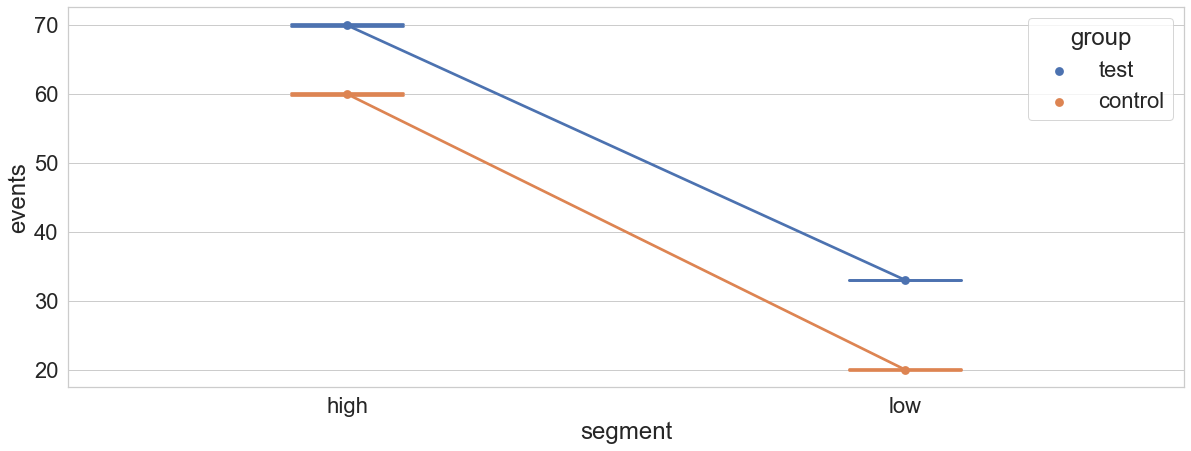

In [58]:
sns.pointplot(x = 'segment', y = 'events', hue = 'group', data = button, capsize = 0.2)

Факторы qroup, segment, а также их взаимодействие оказались значимы. Судя по графку для всех сегментов среднее значение events увеличилось. Поэтому следует ***выкатить новую версию***
